In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from utilities import *
from crossValidation import *
from features import *


In [2]:
# Data
df1 = pd.read_csv('Analysis/data/full_5m_futures/XRPUSDT_futures_5m_202001_202405.csv', index_col=0)
df2 = pd.read_csv('Analysis/data/full_5m_futures/XLMUSDT_futures_5m_202001_202405.csv', index_col=0)
df1.Time = pd.to_datetime(df1.Time, unit='ms')
df2.Time = pd.to_datetime(df2.Time, unit='ms')
df1.set_index('Time', inplace=True)
df2.set_index('Time', inplace=True)

# Pair Price
common_start = max(df1.index[0], df2.index[0])
common_end = min(df1.index[-1],df2.index[-1])

df1 = df1[common_start:common_end]
df2 = df2[common_start:common_end]

In [58]:
lookback = 2000
step = 100
y = getPathMatrix(np.log(df1.Close), df1[lookback:][::step].index, lookback, scale = 1)
x = getPathMatrix(np.log(df2.Close), df2[lookback:][::step].index, lookback, scale = 1)

In [59]:
slope, intercept = vectorized_linear_regression(y.values,x.values)

In [60]:
beta = pd.Series(slope, index = y.index).rolling(window = 1000, min_periods = 50).mean()
beta = pd.Series(index = df1.index, data = beta).bfill().ffill()

<Axes: xlabel='Time'>

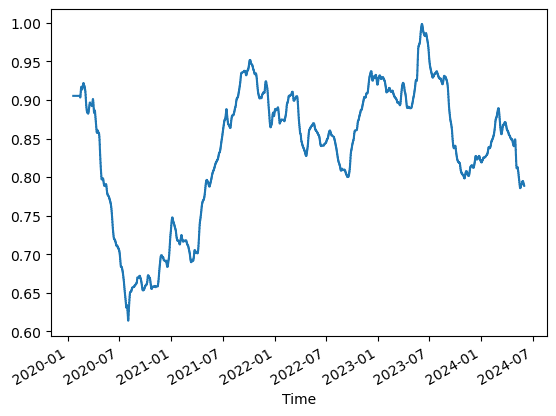

In [61]:
pd.Series(beta).plot()

<Axes: xlabel='Time'>

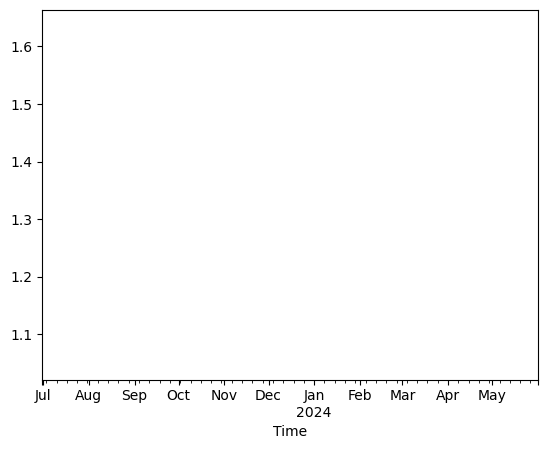

In [62]:
spread = pd.DataFrame()
spread['Close'] = np.log(df1.Close[::step])-np.log(df2.Close[::step])*beta
spread['barID'] = spread.reset_index().index.values
spread['vol'] = spread.Close.rolling(100).std()
spread.Close[pd.to_datetime("2023-06-30"):].plot()

In [63]:
cv_dates = []
for train, test in time_series_cv_dates(num_splits=10, start_date='2020-01-01', end_date='2024-04-30', warm_up_splits=2, gap_days=15):
    cv_dates.append({'train':train,'test':test})

In [64]:
len(cv_dates)

8

In [65]:
out = []

# Start Here

In [66]:
fold = 4

In [34]:
trainStart,trainEnd = cv_dates[fold]['train'][0],cv_dates[fold]['train'][1]
testStart,testEnd = cv_dates[fold]['test'][0],cv_dates[fold]['test'][1]
trainDays = (trainEnd-trainStart).days
testDays = (testEnd-testStart).days
print("Train Days:", trainDays)

Train Days: 926


In [35]:
trainDays_recent = 365
trainStart_recent = trainEnd - pd.Timedelta(days=trainDays_recent)

In [48]:
beta

0.8250475563663705

In [69]:
# Estimate Spread and Volatility
spread = pd.DataFrame()
spread['Close'] = np.log(df1.Close)-np.log(df2.Close)*beta
spread['barID'] = spread.reset_index().index.values
spread['vol'] = spread.Close.rolling(100).std()

In [70]:
# Bollinger Sampling
lookback = 100
feat = getBollinger(spread.Close, lookback, use_log = False)
entry_quantiles = feat.mean() + feat.std()*np.linspace(-3,0, 100)
exit_thres = -0.5
side='long'
tradingDays = 365
commission = 0.001
minVol = commission * 3
targetVol = 0.015

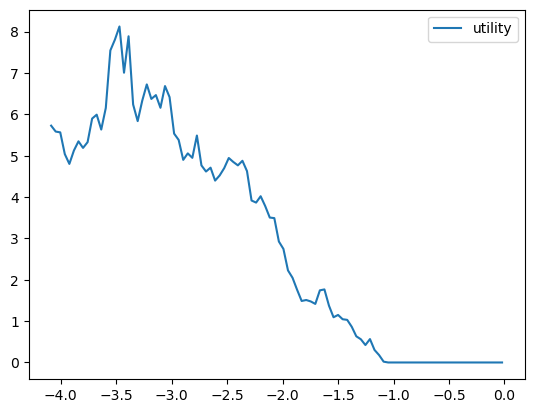

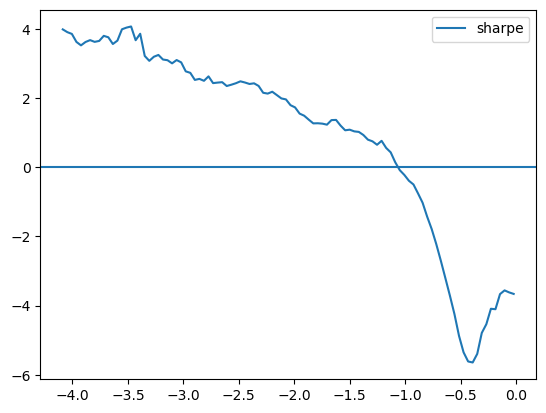

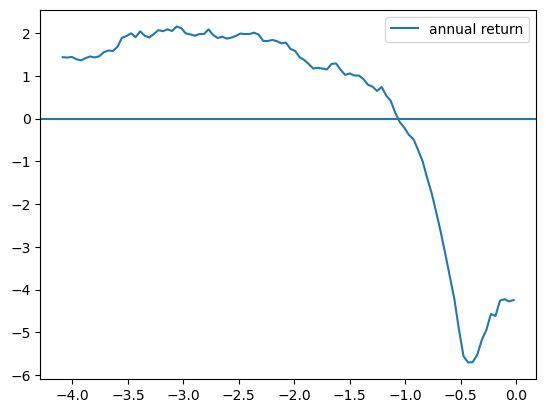

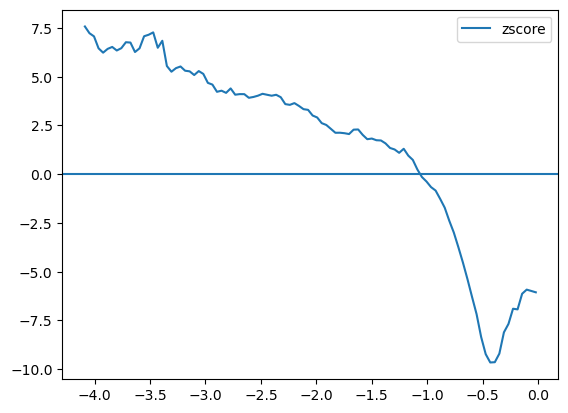

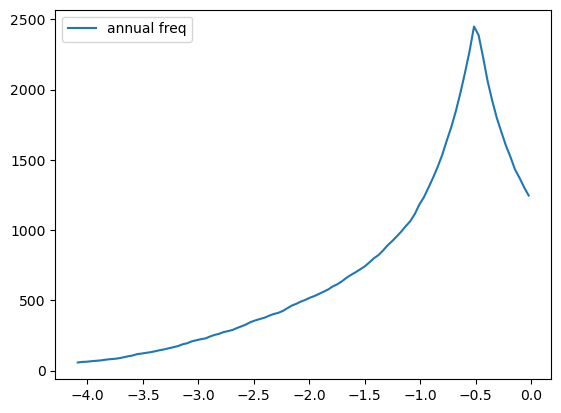

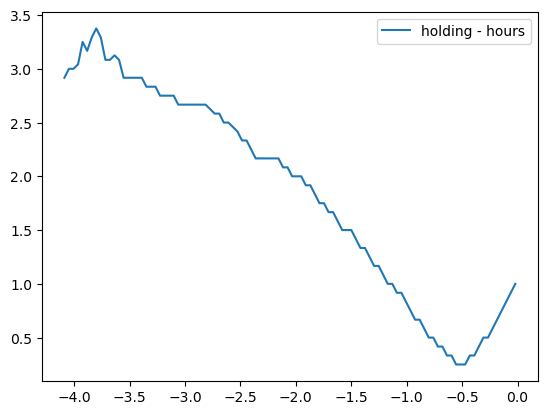

In [71]:
utilities, sharpes, tot_rets = getFeatUtility_pairDE (feat[trainStart:trainEnd], beta, spread, df1, df2, entry_quantiles, 'downward', exit_thres, 'upward',None,None, trainDays, tradingDays, commission, 0, targetVol = targetVol, minVol=minVol, vol = spread['vol'], visual=True)
# utilities_recent, sharpes_recent, tot_rets_recent = getFeatUtility_pairDE (feat[trainStart_recent:trainEnd], beta, spread, df1, df2, entry_quantiles, 'downward', exit_thres, 'upward', None,None,trainDays_recent, tradingDays, commission, mid=0, targetVol = targetVol, minVol=minVol,vol = spread['vol'])
# avg_util = (utilities+utilities_recent)/2
# avg_sharpe = (sharpes+sharpes_recent)/2
# avg_tot_rets = (tot_rets + tot_rets_recent)/2
# avg_util.plot();plt.show()
# utilities_recent.plot();plt.show()
# sharpes_recent.plot()


In [72]:
# Get Samples (events)
commission = 0.001
slippage = 0.0002*2
minVol = (commission+slippage)*2
targetVol = 0.01
events = getCrossingEvents_dynamicExit(feat[testStart:], spread, entry_thres=-3.2, exit_thres1=0, entry_cross='downward', exit_cross1='upward', 
                                       exit_thres2 = None, exit_cross2='downward', mid= 0, minVol = minVol,vol=spread['vol'])

ret1 = get_lrets(events, df1, commission = commission + slippage, side='long', betSize = 1)
ret2 = get_lrets(events, df2, commission = commission + slippage, side='short', betSize = beta)
ret = ret1 + ret2
events['ret1'] = ret1
events['ret2'] = ret2
events['ret'] = ret


lev_adj = spread['vol'][ret.index]/targetVol
ret = np.log((np.exp(ret)-1)/lev_adj + 1)
events['ret_adj'] = ret

<Axes: xlabel='Time'>

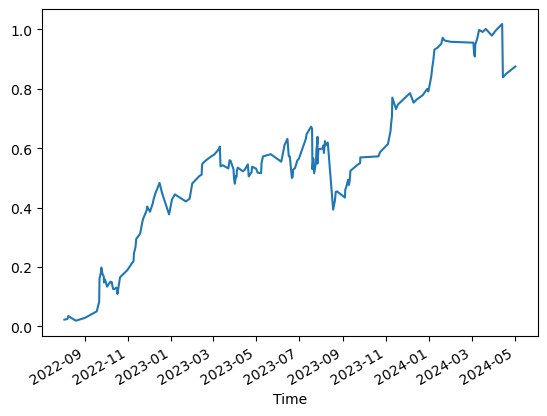

In [57]:
ret.cumsum().plot()

<Axes: xlabel='Time'>

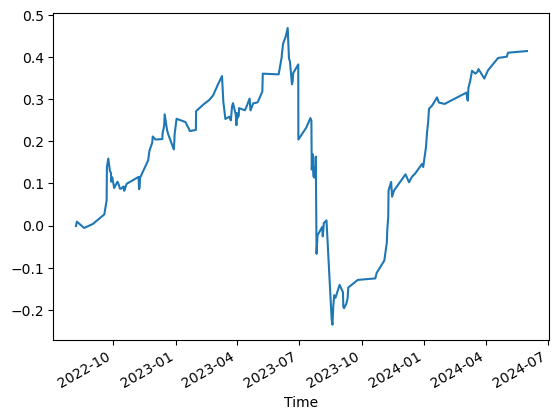

In [74]:
ret.cumsum().plot()

In [37]:
utilities, sharpes, tot_rets = getFeatUtility_pairDE (feat[testStart:testEnd], beta, spread, df1, df2, entry_quantiles, 'downward', exit_thres, 'upward', testDays, tradingDays, commission, 0, targetVol = targetVol, minVol=minVol, vol = spread['vol'], visual=True)

TypeError: getFeatUtility_pairDE() missing 1 required positional argument: 'commission'

In [39]:
entry_thres = -3
exit_thres = -0.5

In [42]:
lookback = 100
commission = 0.001
feat = getBollinger(spread.Close, lookback, use_log = False)
events = getCrossingEvents_dynamicExit(feat, spread, entry_thres, exit_thres, 'downward', 'upward', None, None ,0, minVol = minVol,vol=spread['vol'])
ret1 = get_lrets(events, df1, commission = commission, side='long', betSize = 1)
ret2 = get_lrets(events, df2, commission = commission, side='short', betSize = beta)
ret = ret1 + ret2

lev_adj = spread['vol'][ret.index]/targetVol
ret = np.log((np.exp(ret)-1)/lev_adj + 1)

In [ ]:
ret[trainStart_recent:trainEnd].cumsum().plot()

In [ ]:
out.append(ret[testStart:testEnd])

In [ ]:
combined = pd.concat(out,axis = 0).sort_index()

In [43]:
# Build Feature for pair
# Feature Library
# 13개
def add_featureSet_pairA (X, tEvent, df_spread, scale, lookback):
    # For Pair, don't use log because spread is already a log
    print(f'Adding Pair Features Set A with lookback={lookback} and scale= {scale}')
    # close_path = getPathMatrix(df_spread.Close, tEvent, nbars = lookback, scale = scale)
    # lrets_path = close_path.diff(axis=1)
    
    # X[f'sharpe1_{scale}'] = (lrets_path.sum(axis=1)/np.sqrt((lrets_path**2).sum(axis=1)))
    # X[f'sharpe2_{scale}'] = (lrets_path.sum(axis=1)/lrets_path.std(axis=1))
    # X[f'returns_{scale}'] = lrets_path.sum(axis=1)
    # X[f'std_{scale}'] = lrets_path.std(axis=1)
    # X[f'vol_{scale}'] = np.sqrt((lrets_path**2).sum(axis=1))

    X[f'blgr_{scale}'] = getBollinger(df_spread.Close, lookback*scale, use_log = False)[tEvent]
    X[f'trend_{scale}'] = getTrend(tEvent, df_spread.Close, lookback, scale = scale, use_log=False)
    X[f'trendblgr_{scale}'] = getTrendBlgr(tEvent, df_spread.Close, lookback, scale = scale, use_log=False)
    X[f'willR_{scale}'] = williamsR(df_spread.Close, lookback*scale, nFrac=10)[tEvent]

    # X[f'ar1_{scale}'] = getAR1(tEvent, df_spread.Close, lookback, scale=scale, use_log=False)
    # X[f'adf_{scale}'] = getADF(tEvent, df_spread.Close, lookback, scale=scale,  constant ='c', lags = int(lookback*0.1), use_log=False)                      

    # X[f'macd_norm1_{scale}'] = getMACD_norm(df_spread.Close, span_short = scale*lookback//4, span_long = scale*lookback//2, use_ewm = False, use_log=False)[tEvent]
    # X[f'macd_norm2_{scale}'] = getMACD_norm(df_spread.Close, span_short = scale*lookback//2, span_long = scale*lookback, use_ewm = False,use_log=False)[tEvent]
    return X

def add_featureSet_pairB (X, tEvent, df1, df2, scale, lookback):
    print(f'Adding Pair Features Set B with lookback={lookback} and scale= {scale}')
    close1 = getPathMatrix(df1.Close, tEvent, nbars = lookback, scale = scale)
    close2 = getPathMatrix(df2.Close, tEvent, nbars = lookback, scale = scale)

    slopes, intercepts, residuals = rowwise_regression(X=np.log(close2), Y=np.log(close1))
    X[f'beta_{scale}'] = slopes
    X[f'beta_residual_{scale}'] = residuals
    X[f'beta_norm_{scale}'] = slopes/residuals
    X[f'intercept_{scale}'] = intercepts
    return X

def add_featureSetA (X, tEvent, df, scale, lookback, name = ''):
    print(f'Adding Feature Set A with lookback={lookback} and scale = {scale}')
    close_path = getPathMatrix(df.Close, tEvent, nbars = lookback, scale = scale)
    lrets_path = np.log(close_path).diff(axis=1)
    
    X[f'sharpe1_{scale}{name}'] = (lrets_path.sum(axis=1)/np.sqrt((lrets_path**2).sum(axis=1)))
    X[f'sharpe2_{scale}{name}'] = (lrets_path.sum(axis=1)/lrets_path.std(axis=1))
    X[f'returns_{scale}{name}'] = lrets_path.sum(axis=1)
    X[f'std_{scale}{name}'] = lrets_path.std(axis=1)
    X[f'vol_{scale}'] = np.sqrt((lrets_path**2).sum(axis=1))

    X[f'blgr_{scale}{name}'] = getBollinger(df.Close, lookback*scale)[tEvent]
    X[f'trend_{scale}{name}'] = getTrend(tEvent, df.Close, lookback, scale = scale, use_log=True)
    X[f'trendblgr_{scale}{name}'] = getTrendBlgr(tEvent, df.Close, lookback, scale = scale, use_log=True)
    X[f'willR_{scale}{name}'] = williamsR(df.Close, lookback*scale, nFrac=10)[tEvent]

    X[f'ar1_{scale}{name}'] = getAR1(tEvent, df.Close, lookback, scale=scale, use_log=True)
    X[f'adf_{scale}{name}'] = getADF(tEvent, df.Close, lookback, scale=scale,  constant ='c', lags = int(lookback*0.1),)                      

    X[f'macd_norm1_{scale}{name}'] = getMACD_norm(df.Close, span_short = scale*lookback//4, span_long = scale*lookback//2, use_ewm = False)[tEvent]
    X[f'macd_norm2_{scale}{name}'] = getMACD_norm(df.Close, span_short = scale*lookback//2, span_long = scale*lookback, use_ewm = False)[tEvent]
    return X


In [48]:
X1 = pd.DataFrame(index = events.index)
X2 = pd.DataFrame(index = events.index)
# X = add_featureSet_pairA(X, events.index, spread, scale = 1, lookback = 100)
# X = add_featureSet_pairA(X, events.index, spread, scale = 4, lookback = 100)
# X = add_featureSet_pairA(X, events.index, spread, scale = 12, lookback = 100)

# X = add_featureSet_pairB(X, events.index, df1, df2, scale = 1, lookback = 100)
# X = add_featureSet_pairB(X, events.index, df1, df2, scale = 3, lookback = 100)
# X = add_featureSet_pairB(X, events.index, df1, df2, scale = 12, lookback = 100)

X1 = add_featureSetA(X1, events.index, df1, scale = 1, lookback = 100)
X2 = add_featureSetA(X2, events.index, df2, scale = 1, lookback = 100)

X1 = add_featureSetA(X1, events.index, df1, scale = 4, lookback = 100)
X2 = add_featureSetA(X2, events.index, df2, scale = 4, lookback = 100)

X1 = add_featureSetA(X1, events.index, df1, scale = 12, lookback = 100)
X2 = add_featureSetA(X2, events.index, df2, scale = 12, lookback = 100)

Adding Feature Set A with lookback=100 and scale = 1
Adding Feature Set A with lookback=100 and scale = 1
Adding Feature Set A with lookback=100 and scale = 4
Adding Feature Set A with lookback=100 and scale = 4
Adding Feature Set A with lookback=100 and scale = 12
Adding Feature Set A with lookback=100 and scale = 12


In [49]:
X = X1+X2

In [53]:
Y = pd.DataFrame(index =ret.index)
Y['cont'] = ret
Y['bin'] = (ret>0).astype(int)
print(X.shape, Y.shape)

X_clean = X.replace([np.inf, -np.inf], np.nan)
X_clean = X_clean.dropna()
intersected_indices = X_clean.index.intersection(Y.index)
Y_clean = Y.loc[intersected_indices]
X_clean = X_clean.loc[intersected_indices]
print(X_clean.shape, Y_clean.shape)

(732, 39) (732, 2)
(731, 39) (731, 2)


In [54]:
# X_train, X_test, Y_train, Y_test = X_clean.loc[trainStart_recent:trainEnd], X_clean.loc[testStart:testEnd], Y_clean.loc[trainStart_recent:trainEnd], Y_clean.loc[testStart:testEnd]
X_train, X_test, Y_train, Y_test = X_clean.loc[trainStart:trainEnd], X_clean.loc[testStart:testEnd], Y_clean.loc[trainStart:trainEnd], Y_clean.loc[testStart:testEnd]
print('default precision:', Y_test[Y_test['cont']>0]['cont'].sum()/Y_test['cont'].abs().sum())

default precision: 0.6652966332770619


In [55]:
# RF Simple
clf = RandomForestClassifier(n_estimators=500, max_depth = 1, min_samples_leaf = 0.3, max_features=X.shape[1]//3,random_state=2, bootstrap = True, n_jobs=-1,)
clf.fit(X_train, Y_train.bin, sample_weight=Y_train.cont.abs())
y_proba_train = clf.predict_proba(X_train)[:,1]
y_proba_test = clf.predict_proba(X_test)[:,1]

In [63]:
# Classification report
y_pred_test = (y_proba_test > 0.55).astype(int)
print("percent of samples:", y_pred_test.sum()/len(y_pred_test)) 
print()
print(classification_report(Y_test['bin'], y_pred_test))#, sample_weight=Y_test['ret'].abs()))

percent of samples: 0.8431372549019608

              precision    recall  f1-score   support

           0       0.25      0.13      0.17        15
           1       0.70      0.83      0.76        36

    accuracy                           0.63        51
   macro avg       0.47      0.48      0.47        51
weighted avg       0.57      0.63      0.59        51



In [68]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# Initialize the logistic regression model
clf = LogisticRegression(max_iter= 1000, penalty = 'l2', random_state =1, C = 1)

# Train the model
clf.fit(X_train, Y_train.bin, sample_weight = Y_train.cont.abs())
y_proba_test = clf.predict_proba(X_test)[:,1]

In [69]:
bet_size =np.maximum(2*y_proba_test-1,0)

In [71]:
# Classification report
y_pred_test = (y_proba_test > 0.6).astype(int)
print("percent of samples:", y_pred_test.sum()/len(y_pred_test)) 
print()
print(classification_report(Y_test['bin'], y_pred_test, sample_weight=Y_test['cont'].abs()))

percent of samples: 0.6774193548387096

              precision    recall  f1-score   support

           0       0.53      0.25      0.34 1.2154774908432688
           1       0.48      0.76      0.59 1.1177028062401173

    accuracy                           0.49 2.333180297083386
   macro avg       0.51      0.50      0.46 2.333180297083386
weighted avg       0.51      0.49      0.46 2.333180297083386



In [ ]:
# selected = Y_test.cont[y_proba_test>0.6]
selected = np.log((np.exp(Y_test.cont)-1)*bet_size*2+1)
selected.cumsum().plot(label='model')
print(selected.shape)
print(len(ret[testStart:testEnd]))
ret[testStart:testEnd].cumsum().plot(label='default')
plt.legend();plt.show()

In [ ]:
out.append(selected)

In [ ]:
combined = ret[pd.to_datetime("2022-04-01"):]

In [ ]:
combined = pd.concat(out, axis = 0).sort_index()

In [ ]:
combined.cumsum().plot()

In [ ]:
import quantstats as qs
qs.reports.full(np.exp(combined)-1)

In [20]:
# Save Model
import pickle
with open('Analysis/[S2] XRP_XLM_Pair/events.pkl', 'wb') as f:
    pickle.dump(events, f)